In [20]:
# from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyro
import seaborn as sns
import torch
# from math import ceil, floor
import functools
import dill
import sys

import bayes_air.utils.dataloader as ba_dataloader
from bayes_air.model import augmented_air_traffic_network_model_simplified
# from bayes_air.network import NetworkState, AugmentedNetworkState
# from bayes_air.schedule import split_and_parse_full_schedule

from scripts.lga.lga_network import *

from tqdm.notebook import tqdm

from pathlib import Path

from scripts.lga.lga_training import WeatherThreshold, ClusterThreshold

plt.rcParams['font.size'] = 8
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300

dir_path = Path.cwd()

class AirportProcess:
    def __init__(self, airport):
        rng_seed = 1

        pyro.clear_param_store()  # avoid leaking parameters across runs
        pyro.enable_validation(True)
        pyro.set_rng_seed(int(rng_seed))

        # day_strs_list = [['2019-07-04'], ['2019-07-10'], ['2019-07-18'], ['2019-07-15'], ['2019-07-05'], ['2019-07-06']]
        # day_strs_list = [
        #     [f'2019-{j:02d}-{i:02d}']
        #     for i in range(1,32)
        #     for j in (7,)
        # ] + [['2019-05-03']]
        self.day_strs_list = [['2019-07-15']]
        self.network_airport_codes = airport.split(',')
        dt = .1

        self.device = torch.device("cpu")

        # Hyperparameters
        initial_aircraft = 50.0 # not used!
        mst_effective_hrs = 24 # not used!
        mst_split = 1 # not really used

        self.subsamples = {}

        for day_strs in self.day_strs_list:
            # gather data
            days = pd.to_datetime(day_strs)
            data = ba_dataloader.load_remapped_data_bts(days, self.network_airport_codes[0])
            name = day_strs[0]

            num_days = len(days)
            num_flights = sum([len(df) for df in data.values()])

            # make things with the data
            travel_times_dict, observations_df = \
                make_travel_times_dict_and_observation_df(
                    data, self.network_airport_codes
                ) 
            states = make_states(data, self.network_airport_codes)

            model = functools.partial(
                augmented_air_traffic_network_model_simplified,

                travel_times_dict=travel_times_dict,
                initial_aircraft=initial_aircraft,

                include_cancellations=False,
                mean_service_time_effective_hrs=mst_effective_hrs,
                delta_t=dt,

                source_use_actual_departure_time=True,
                source_use_actual_cancelled=False,
            )

            self.subsamples[name] = {
                "model": model,
                "states": states,
                "travel_times_dict": travel_times_dict,
                "observations_df": observations_df,
            }

        print(self.subsamples.keys())


    def get_samples_df(self, name, mst, n, airport='JFK'):
        sdd = pd.DataFrame()
        add = None
        for i in tqdm(range(n)):
            posterior_samples = {
                f'{airport}_0_mean_service_time': torch.tensor([mst]).to(self.device)
            }
            print(f'Posterior samples: {posterior_samples}')
            # raise NotImplementedError('This is not implemented yet!')

            s = self.subsamples[name]
            model, states, observations_df = s["model"], s["states"], s["observations_df"]

            # print('Model: ', model, '\n\nStates: ', states, '\n\nObservations: ', observations_df)
            hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df, airport)
            sdd[i] = hourly_delays.sample_departure_delay
            # print(hourly_delays)
            # print('Actual departure delay: ', hourly_delays.actual_departure_delay)
            if i == 0:
                add = hourly_delays.actual_departure_delay
        return sdd, add
    

    def transform_sample(self, sample):
        return .004 * sample + .02


    def get_samples_df_using_guide(self, name, guide, label, n):
        sdd = pd.DataFrame()
        add = None
        samples = self.transform_sample(guide(label).sample((n,)))
        for i in tqdm(range(n)):
            posterior_samples = {
                f'{self.network_airport_codes[0]}_0_mean_service_time': samples[i]
            }
            print(f'Posterior samples: {posterior_samples}')
            s = self.subsamples[name]
            model, states, observations_df = s["model"], s["states"], s["observations_df"]
            hourly_delays = get_hourly_delays_from_z_sample(model, posterior_samples, states, observations_df, self.network_airport_codes[0])
            sdd[i] = hourly_delays.sample_departure_delay
            # print(hourly_delays)
            # print actual
            # print(hourly_delays.actual_departure_delay)
            if i == 0:
                add = hourly_delays.actual_departure_delay

        mst = samples.mean().item()
        return sdd, add
    

    def plot_delays(self, sac_list, include_samples=False, figsize=(3.5,3.5), ylimupper=4.55, sim_msg='predicted'):
        fig, ax = plt.subplots(figsize=figsize, dpi=300)
            
        ylim = (-.05,ylimupper)
        xlim = (5,25)

        for name, sdd, add, c in sac_list:

            sm = sdd.mean(axis=1)
            sd = sdd.std(axis=1)
            # print(len(sm), len(sd))

            ax.plot(sm, f':{c}', linewidth=1.0, label=f'{name} ({sim_msg})')
            ax.fill_between(sdd.index, sm+sd, sm-sd, alpha=0.2, color=c)

            if include_samples:
                sdd.plot(ax=ax, legend=False, style=f'-{c}', alpha=.2)
            add.plot(ax=ax, legend=False, style=f'-{c}', alpha=1, label=f'{name} (actual)', linewidth=1.0)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xlabel(f'Hour of day ({self.network_airport_codes[0]} local time)', fontsize=8)
        ax.set_ylabel('Average hourly delay (hours)', fontsize=8)

        ax.legend(fontsize=6)

        ax.set_xticks(np.arange(6, 27, 3))
        
        return fig
    
    def get_label_guide(self, name):
        dir_path = Path.cwd()

        # /bayes-air-atrds-attempt-8/checkpoints/nsf_730
        # ckpt_path = dir_path / 'jfk-training-attempt-0/final/nsf_730/final/output_dict.pkl'
        ckpt_path = dir_path / f'{self.network_airport_codes[0].lower()}-training-attempt-0/checkpoints/nsf_1/final/output_dict.pkl'

        with open(ckpt_path, 'rb') as f:
            output_dict = dill.load(f)

        self.guide = output_dict['guide']

        wt = WeatherThreshold(50., self.device, 0., 0.)
        ct = ClusterThreshold(50., self.device, 0., 0.) # dummy init

        wt.load_state_dict(output_dict['wt_state_dict'])
        ct.load_state_dict(output_dict['ct_state_dict'])

        extras_path = dir_path / 'extras'

        processed_visibility = pd.read_csv(extras_path / 'processed_visibility.csv')
        visibility_dict = dict(processed_visibility.values)
        processed_ceiling = pd.read_csv(extras_path / 'processed_ceiling.csv')
        ceiling_dict = dict(processed_ceiling.values)

        processed_x = pd.read_csv(extras_path / 'x_capacity_counts.csv') # TODO: option
        x_dict = dict(processed_x.values)
        processed_y = pd.read_csv(extras_path / 'y_event_delays.csv') # TODO: option
        y_dict = dict(processed_y.values)

        y_threshold = output_dict["y_th"]
        x_threshold = output_dict["x_th"]

        def get_label(name):
            y = y_dict[name]
            x = x_dict[name]
            y_label = 1.0 if y > y_threshold else 0.0
            x_label = 1.0 if x > x_threshold else 0.0
            y_label = torch.tensor([y_label])
            x_label = torch.tensor([x_label])

            label = ct.assign_label(y_label, x_label, visibility_dict[name], ceiling_dict[name])
            # print(label)
            return label

        self.c_label = get_label(name)



In [3]:
jfk_ap = AirportProcess('JFK')
sdd_jfk, add_jfk = jfk_ap.get_samples_df('2019-07-15', .020, 1, airport='JFK')

dict_keys(['2019-07-15'])


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

dict_keys(['2019-07-15'])


  0%|          | 0/2 [00:00<?, ?it/s]

Posterior samples: {'LAX_0_mean_service_time': tensor([0.1500])}
Posterior samples: {'LAX_0_mean_service_time': tensor([0.1500])}


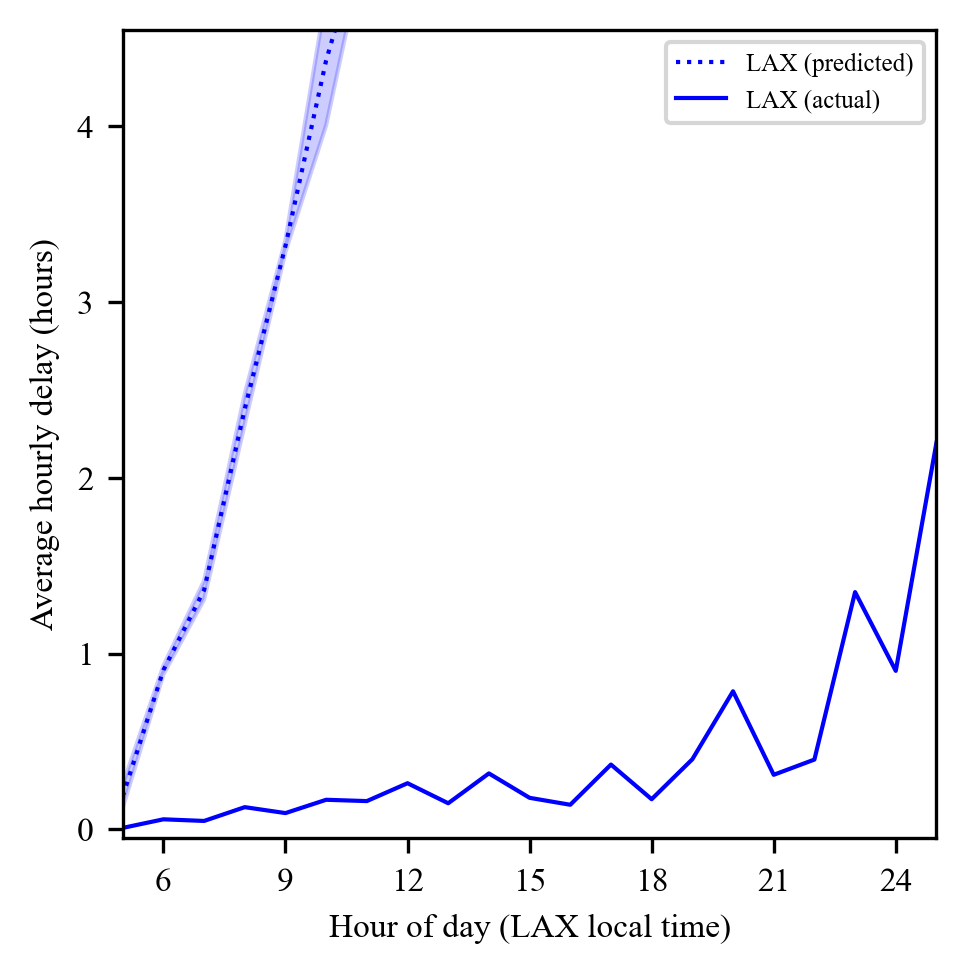

In [ ]:
# brief retest for lax
lax_ap = AirportProcess('LAX')
lax_ap.get_label_guide('2019-07-15')
sdd_lax, add_lax = lax_ap.get_samples_df('2019-07-15', .1, 2, airport='LAX')

# sdd_2_lax, add_2_lax = lax_ap.get_samples_df_using_guide('2019-07-15', lax_ap.guide, lax_ap.c_label, 20)
# get mst from sdd_2_lax

# plot everything
fig = lax_ap.plot_delays(
    sac_list=[
        ('LAX', sdd_lax, add_lax, 'b')],
    sim_msg='predicted')

# fig2 = lax_ap.plot_delays(
#     sac_list=[
#         ('LAX', sdd_2_lax, add_2_lax, 'b')],
#     sim_msg='predicted using guide')

In [23]:
sdd_lax

,0,1
0,0.219269,0.289377
1,0.695862,0.724889
2,0.866313,0.811367
4,NaN,NaN
5,0.318245,0.328054
6,1.006210,0.760977
7,1.903012,1.463976
8,2.697790,2.362153
9,3.396715,3.468132
10,4.391530,3.910322


dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

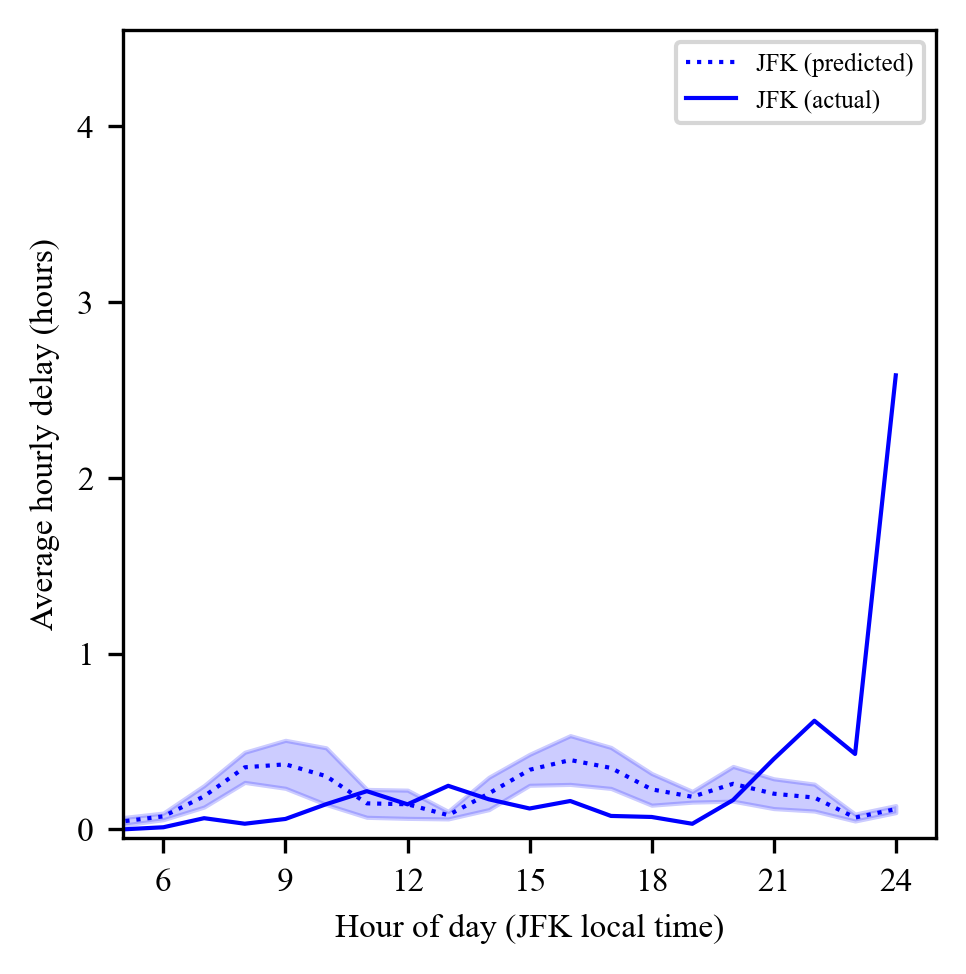

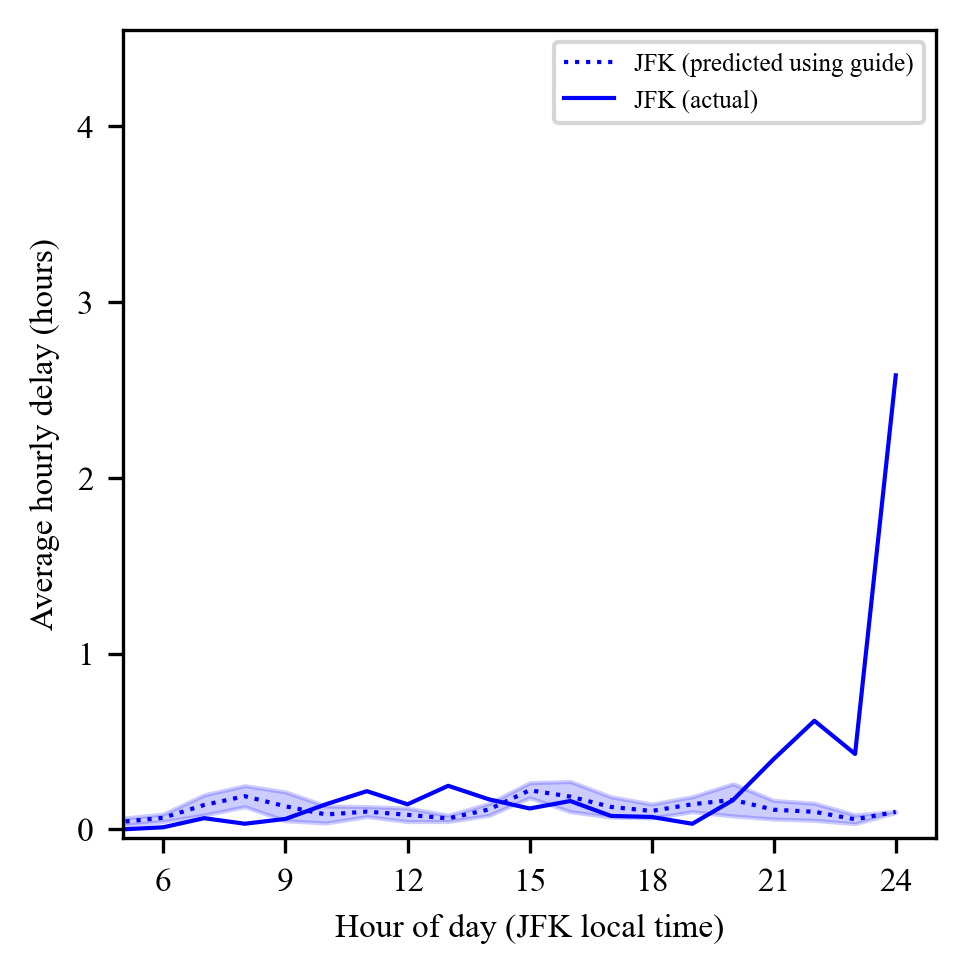

In [ ]:
# # brief test for JFK
# jfk_ap = AirportProcess('JFK')
# sdd_jfk, add_jfk = jfk_ap.get_samples_df('2019-07-15', .020, 20, airport='JFK')

# sdd_2_jfk, add_2_jfk = jfk_ap.get_samples_df_using_guide('2019-07-15', guide, c_label, 20)

# # plot everything
# fig = jfk_ap.plot_delays(
#     sac_list=[
#         ('JFK', sdd_jfk, add_jfk, 'b')],
#     sim_msg='predicted')

# fig2 = jfk_ap.plot_delays(
#     sac_list=[
#         ('JFK', sdd_2_jfk, add_2_jfk, 'b')],
#     sim_msg='predicted using guide')

dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

dict_keys(['2019-07-15'])


  0%|          | 0/20 [00:00<?, ?it/s]

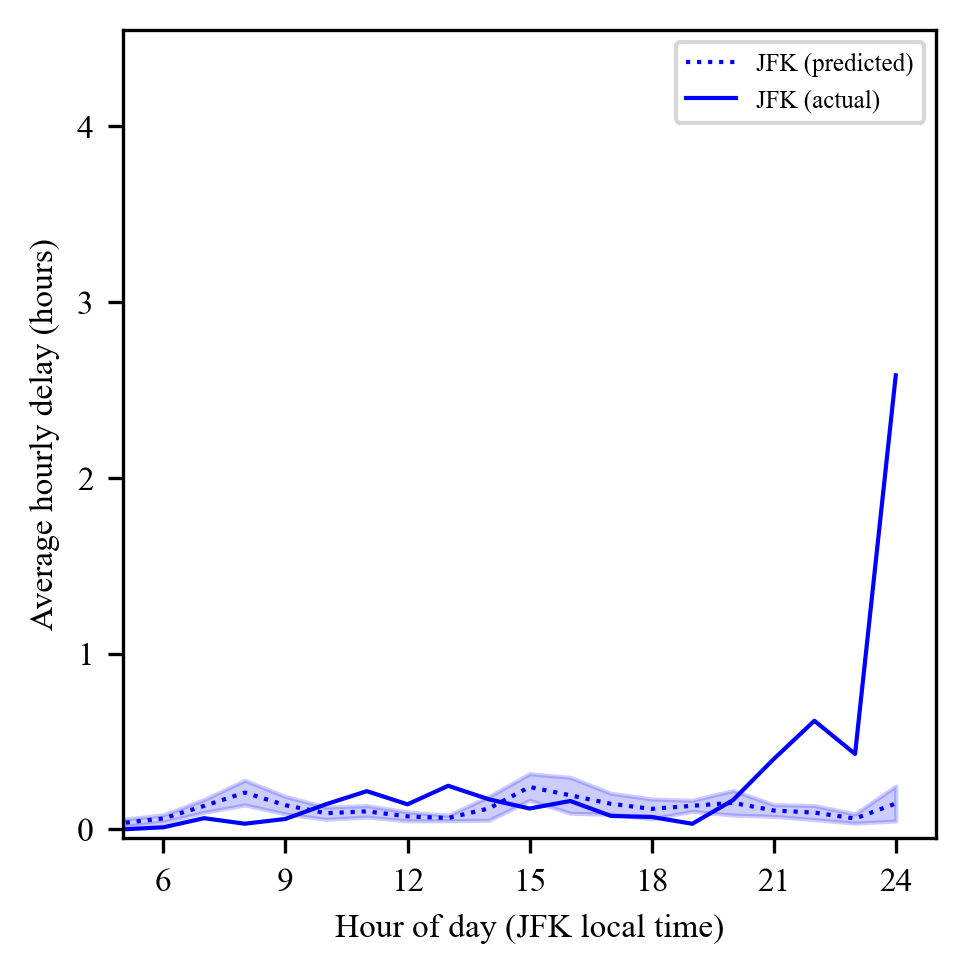

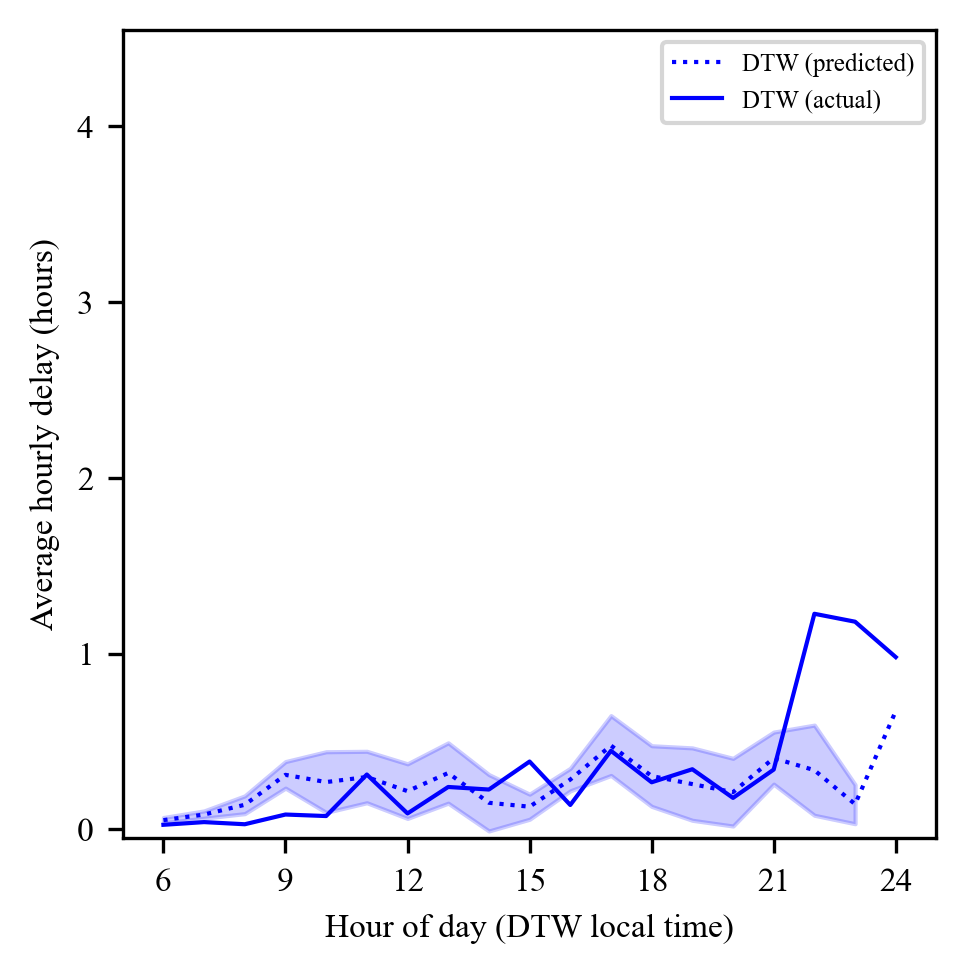

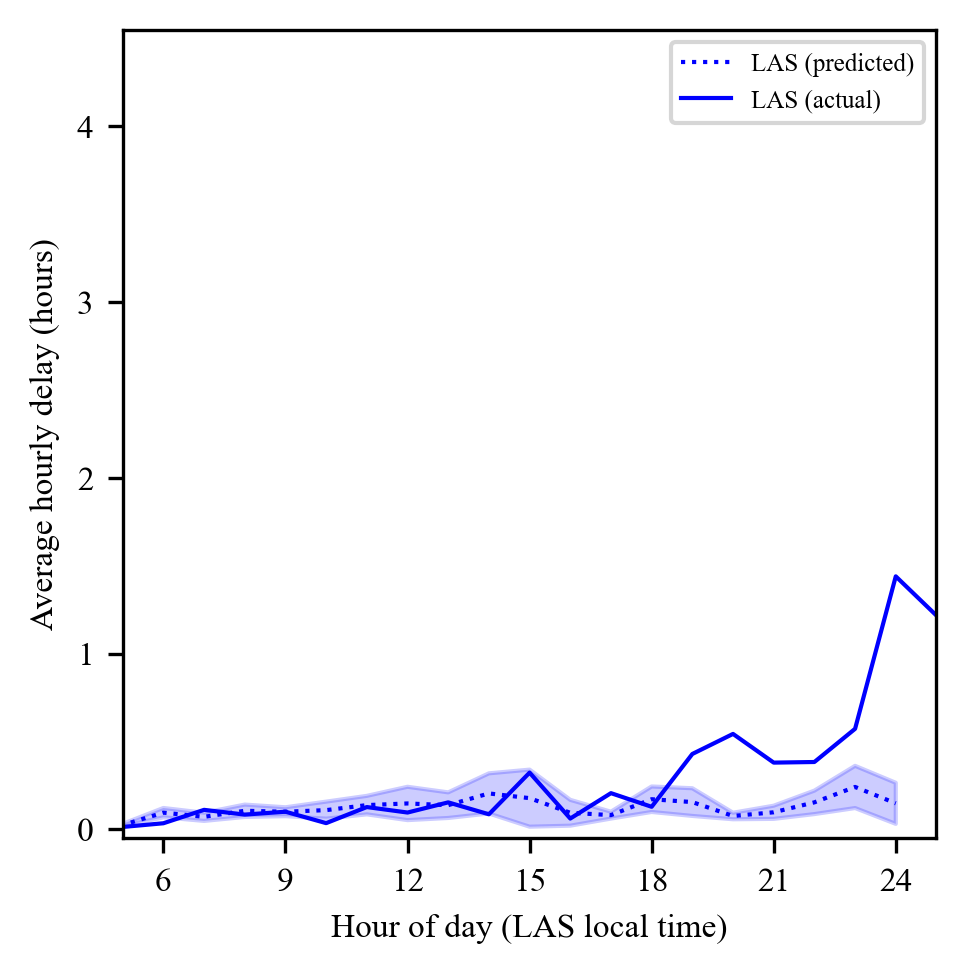

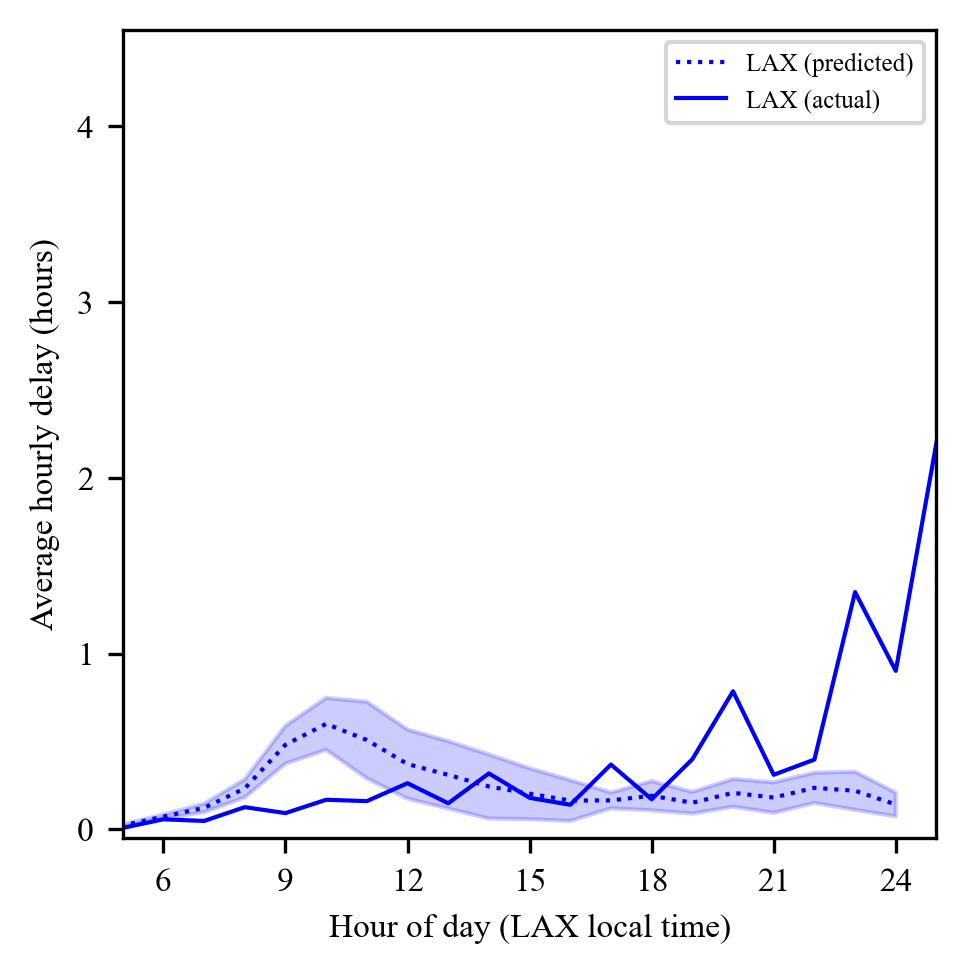

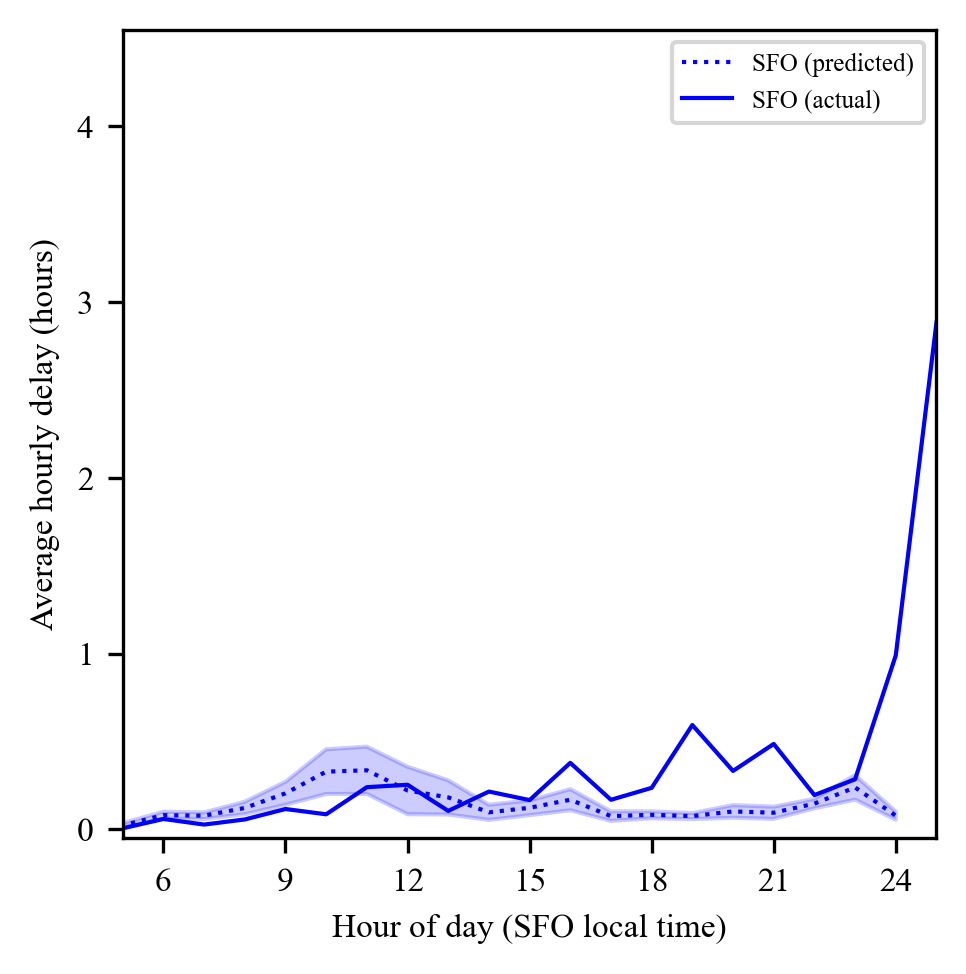

In [16]:
airports = ['JFK', 'DTW', 'LAS', 'LAX', 'SFO']
date = '2019-07-15'
for apt in airports:
    ap = AirportProcess(apt)
    ap.get_label_guide(date)
    # sdd_a, add_a = ap.get_samples_df('2019-07-15', .020, 20, airport=apt)

    sdd_2_a, add_2_a = ap.get_samples_df_using_guide(date, ap.guide, ap.c_label, 20)

    # plot everything
    fig = ap.plot_delays(
        sac_list=[
            (apt, sdd_2_a, add_2_a, 'b')],
        sim_msg='predicted')

Text(0, 0.5, 'posterior samples')

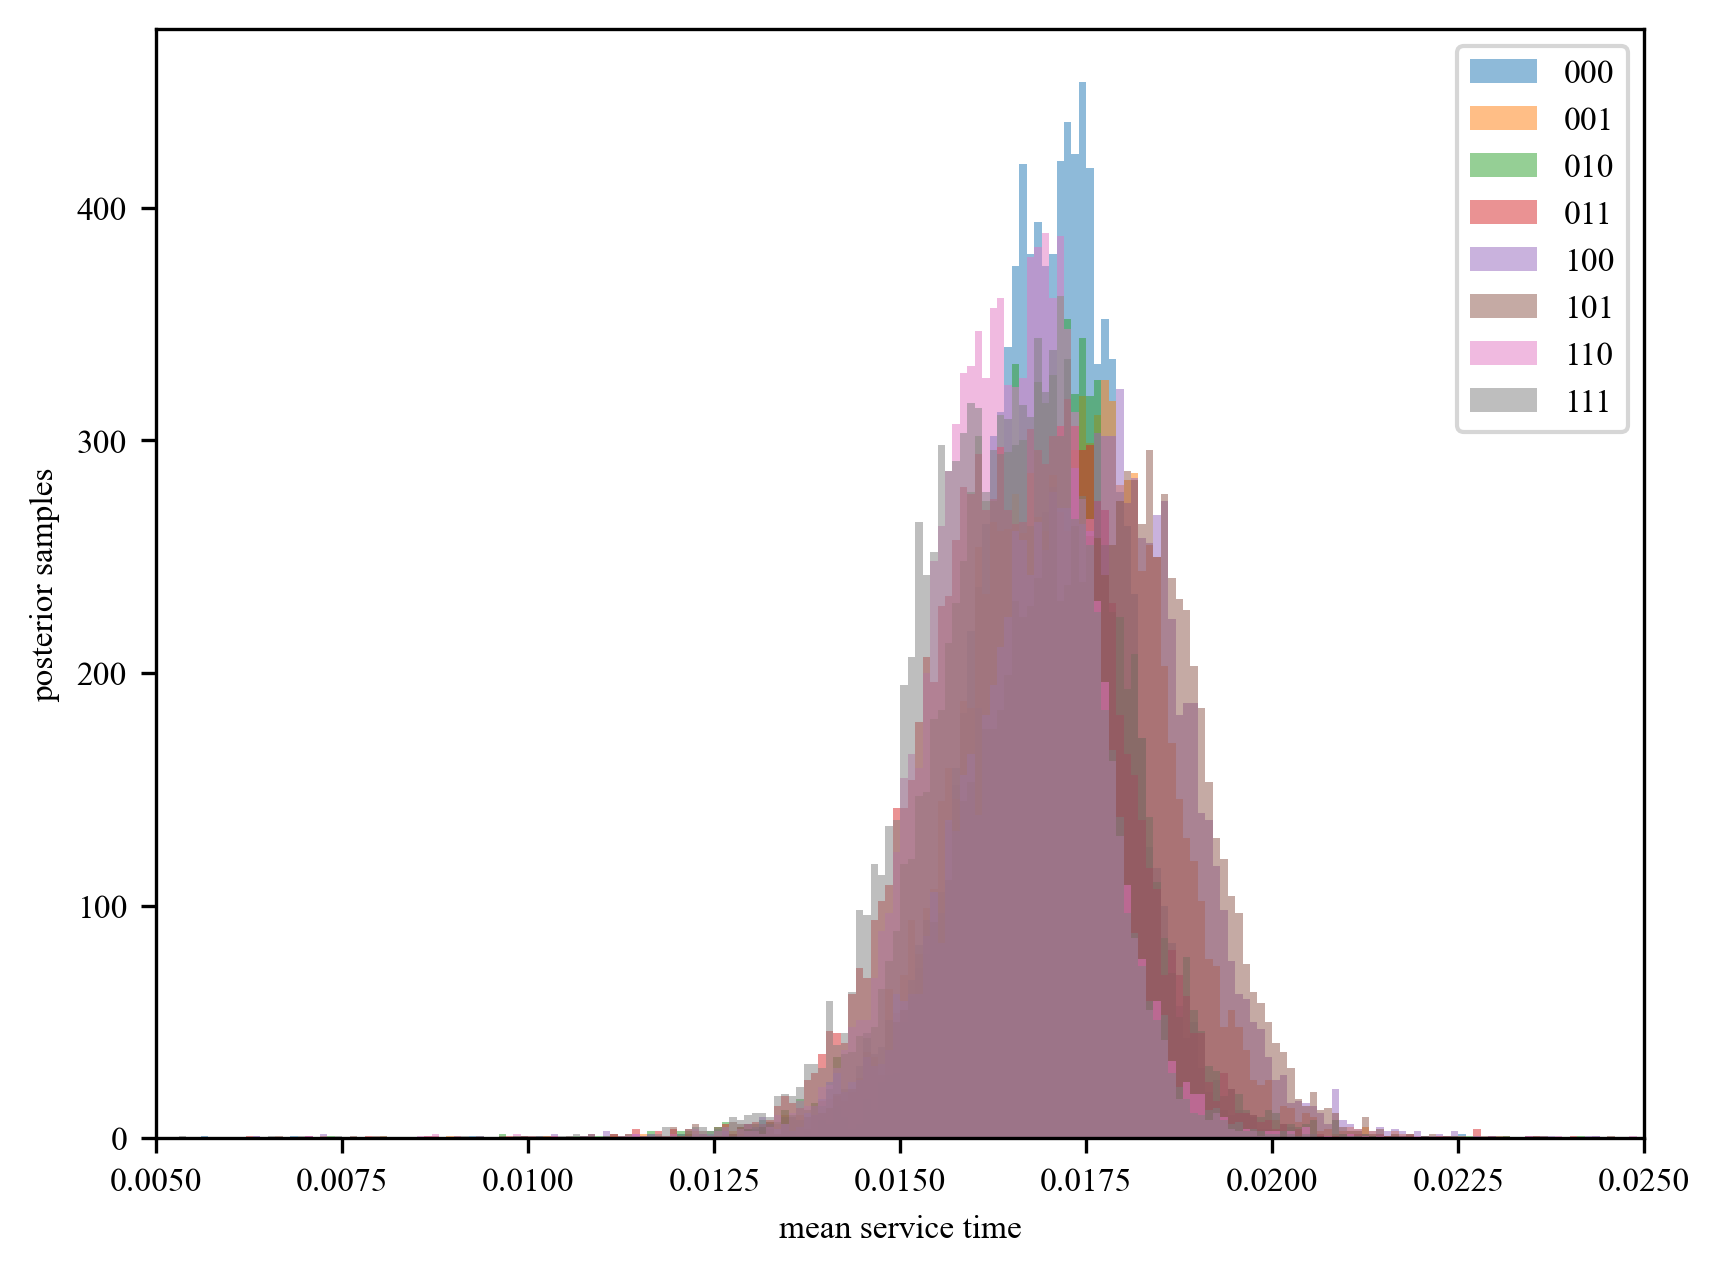

In [4]:
dir_path = Path.cwd()

# /bayes-air-atrds-attempt-8/checkpoints/nsf_730
# ckpt_path = dir_path / 'bayes-air-atrds-attempt-8/final/nsf_730/final/output_dict.pkl'

ckpt_path = dir_path / f'jfk-training-attempt-0/checkpoints/nsf_1/final/output_dict.pkl'
with open(ckpt_path, 'rb') as f:
    output_dict = dill.load(f)

guide = output_dict['guide']

labels = []
names = []

for y in range(2):
    for x in range(2):
        for w in range(2):
            label = torch.zeros(5, dtype=torch.float)
            label[2*y+x] = 1.0
            label[4] = w
            labels.append(label)
            names.append(f'{y}{x}{w}')

def transform_sample(sample):
    return .004 * sample + .02

n_samples = 10000

fig, ax = plt.subplots()
# for label, color in zip(labels, ['b', 'r']):
bins = np.arange(.0050, .0351, .0001)
for label, name in zip(labels, names):
    # print(label)
    samples = transform_sample(guide(label).sample((n_samples,)))
    ax.hist(
        samples, 
        alpha=.5, 
        fill=True, 
        edgecolor='k', 
        bins=bins,
        linewidth=0,
        label=f'{name}',
    )
    
ax.set_xlim(0.005,.025)
ax.legend()
ax.set_xlabel("mean service time")
ax.set_ylabel("posterior samples")

In [ ]:
q_samples = {}

for label, name in zip(labels, names):
    q_samples[name] = transform_sample(guide(label).sample((n_samples,))).squeeze().detach().cpu().numpy()

print(q_samples)

In [ ]:
def plot_from_labels_names(samples, labels, names, title=None, figsize=(3.5,3.5)):

    plotting_df = {}

    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # groups = samples.keys()
    groups = names

    for group in groups:
        plotting_df[group] = pd.DataFrame(
            {
                "Mean service time (hours)": samples[group],
                "group": group,
            },
        ) 

    for group in groups:
        
        sns.histplot(
            x="Mean service time (hours)",
            data=plotting_df[group],
            ax=ax,
            binwidth=.0001,
            stat="density",
            # shrink=0.8,
            # hue="group",
            # palette=palette,
            edgecolor='none',
            # label=r"$\mathdefault{g_\gamma}\to$" + f"{''.join(list(group))}",
            label=f"{''.join(list(group))}",
            kde=True,
            line_kws=dict(linewidth=1),
        )

        print(f"{group} posterior, mean={samples[group].mean():.5f}, std={samples[group].std():.5f}")
    
    ax.set_xlabel("Mean service time (hours)", fontsize=8)
    ax.set_ylabel("Density", fontsize=8)
    

    ax.set_xlim(.008, .022)
    # ax.set_title("mean service time posteriors" if title is None else title)
    ax.legend(
        # title='Posterior', 
        fontsize=7,
        handlelength=.7,
        handletextpad=.3,
    )

    return fig

fig = plot_from_labels_names(q_samples, labels, names, figsize=(3.16,3.5))
# for ext in ('png', 'eps', 'pdf'):
#     plt.savefig(f'paper_plots/q_phi_nsf_730_all.{ext}', bbox_inches='tight', pad_inches=0)
